# KES IR data - taken in feb 2024
taken along C axis

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import PyCrystalField as cef
import scipy
from scipy.optimize import minimize
from scipy.optimize import leastsq
import pandas as pd
import lmfit

plt.ion()

 *******************************************************
 *                PyCrystalField 2.3.9                 *
 *  Please cite  J. Appl. Cryst. (2021). 54, 356-362   * 
 *    <https://doi.org/10.1107/S160057672001554X>      *
 *******************************************************



# first, dfine some global vars

In [346]:
B20 = -2.773e-2
B40 = -3.987e-4
B43 = -1.416e-2
B60 = 3.152e-6
B63 = -7.616e-6
B66 = 3.275e-5

temperature = 5 # in K

muB = 5.7883818012e-2  # meV/T
mu0 = np.pi*4e-7       # T*m/A
kB  = 8.617e-2         # [meV/K];
meVToCm =meVTocCmInv= 8.066 
ion = 'Er3+'

kBT = kB*temperature

# import data
KES was already normalized in matlab, so we're skipping those steps

In [554]:
# okay, so next step is import the data and do a ZF subtraction
fname = '/Users/hopeless/Desktop/LeeLab/data/IR_MagLab_Feb2024/KErSe2Norm0Field.txt'


rawData = pd.read_csv(fname, index_col=0,  header=0, delimiter = '\t')
normDataC = rawData
normDataC = 2-normDataC
normDataC = normDataC.drop(labels = 16.995, axis=0)

# cutting off noisy data with no lines

for col in normDataC.columns:
    if float(col)<20.: 
        normDataC = normDataC.drop(labels=col , axis = 1)
    if float(col)>50.:
        normDataC = normDataC.drop(labels=col , axis = 1)

for col in normDataC.columns:
    for idx in normDataC.index: 
        if normDataC.loc[idx, col]<.1: 
            normDataC.loc[idx, col] = 0

In [555]:
# lets get bfield + wavenum arrays from the dataframe
Bfield =[float(i) for i in normDataC.index.values]
wavenums = [float(b) for b in normDataC.columns.values]

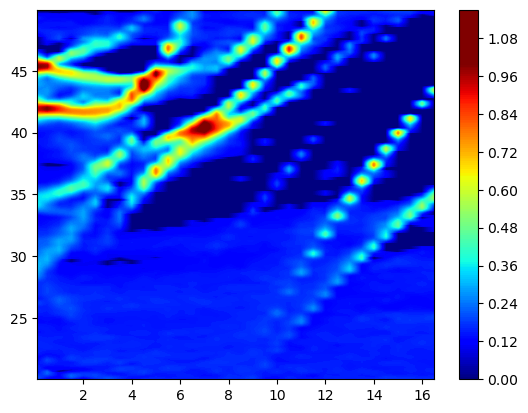

In [556]:
# quickly plot to make sure data doesn't look terrible
plt.ion()
plt.contourf(Bfield, wavenums, normDataC.T, 200, cmap = 'jet')
# plt.ylim(40,50)
plt.clim(0,1)
plt.colorbar()

# define the functions we need
usually, I do this by creating a class to do what I want, so I wouldn't have to keep redefining functions
I have not done this yet because there's so many different datasets and they are all formatted slightly differently

In [557]:
# functions we'll use to fit

def gaussian(x, amp,cen , wid):
    return amp * np.exp(-(x-cen)**2 / wid)

def diagonalize(ionObj, ion, Field): 
    JdotB = muB*(Field*cef.Operator.Jz(ionObj.J))*cef.LandeGFactor(ion)
    H = np.sum([a*b for a,b in zip(ionObj.O, ionObj.B)], axis=0)
    ionObj.diagonalize(H + JdotB.O) # this is just H = Hcef + Hmag
    return ionObj.eigenvalues 

def zeemanSplit(field, wavenum, B20, B40, B43, B60, B63, B66):     
    # assuming only H||B rn
    # assuming that x is an array
    amp =  [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]#[0, .15, .15, .2, 0.15,0.15,0.15,0.15,0.07,0.07, .1,.1,.1,.1,.1]
    Bparams =  {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
    ionObj = cef.CFLevels.Bdict(ion,Bparams)
    try: # for the case we pass in a single B val
        evals = diagonalize(ionObj, ion, field)
        dE =[eval for eval in evals] # this is the spitting if everything is in the GS -> not necessarily true for finite temp
        # first, lets calculate the partition function - the microstates of the system don't change, jsut the number of abs line
        # we can make between them, so we can make this now
        # Z = sum_i (e^(-beta*E_i))
        Z = [np.exp(-Ei/kBT) for Ei in dE]
        Z = sum(Z)
        # now that we have the partition fn, we can calculate probabilities
        p = [1/Z*np.exp(-Ei/kBT) for Ei in dE]
        # okay, so now we want to add lines between non ground states 
        # we want the amplitude to be the probability -> main lines are already determined
        numLines = len(dE)
        for i in range(1,numLines): 
            # skip GS - already have those dE
            for j in range(i+1, numLines):
                temp = dE[j]-dE[i]
                dE.append(temp)
                amp.append(p[i]*amp[i])
        # so now we want to create a multi gaussian with centers at the eigenvalues
        wid = .1 # pulled this out my ass, .5cm-1 resolution roughly
        a = amp[0] #+ m[0]*field
        centers =dE 
        fun = gaussian(wavenum, a, centers[0]*meVToCm, wid)
        for i in range(len(centers[1:])):
            a = amp[i]# +m[i]*field
            fun += gaussian(wavenum, a, centers[i]*meVToCm, wid)
    except AttributeError : # for when we pass in an array 
        # pyCrystalField has trouble with the operators because its not *just* a function
        # so this error handling lets us have a function that works for single values and array inputs
        fun = []
        for b in field: 
            evals = diagonalize(ionObj, ion, b)
            dE =[eval for eval in evals] # this is the spitting if everything is in the GS -> not necessarily true for finite temp
            # first, lets calculate the partition function - the microstates of the system don't change, jsut the number of abs line
            # we can make between them, so we can make this now
            # Z = sum_i (e^(-beta*E_i))
            Z = [np.exp(-Ei/kBT) for Ei in dE]
            Z = sum(Z)
            # now that we have the partition fn, we can calculate probabilities
            p = [1/Z*np.exp(-Ei/kBT) for Ei in dE]
    
            # okay, so now we want to add lines between non ground states 
            # we want the amplitude to be the probability -> main lines are already determined
            numLines = len(dE)
            for i in range(1,numLines): 
                # skip GS - already have those dE
                for j in range(i+1, numLines):
                    temp = dE[j]-dE[i]
                    dE.append(temp)
                    amp.append(p[i]*amp[i])
            # so now we want to create a multi gaussian with centers at the eigenvalues
            wid = .5 # pulled this out my ass, .5cm-1 resolution roughly
            a = amp[0] #+ m[0]*field
            centers =dE 
            tempfun = gaussian(wavenum, a, centers[0]*meVToCm, wid)
            for i in range(len(centers[1:])):
                a = amp[i]# +m[i]*field
                tempfun += gaussian(wavenum, a, centers[i]*meVToCm, wid)
            fun.append(tempfun)
    return fun

# functions we'll use to plot
def zeemanSplit3d(ionObj, ion, Field): 
    # ion input is cef.CFLevels.Bdict(ion,Bparams) type of variable
    # magnetic hamiltonian -> here we are using a magnetic dipole in a uniform, static field
    # this gives potential V = -mu.B
    # for our electrons, we can rewrite mu = gumBJ, with some prefactor
    # here J is our total ang mom. J = L+S
    JdotB = muB*(Field[0]*cef.Operator.Jx(ionObj.J) 
                 + Field[1]*cef.Operator.Jy(ionObj.J) 
                 + Field[2]*cef.Operator.Jz(ionObj.J))*cef.LandeGFactor(ion)
    #we've defined this as a CFLevels object
    # define just the CEF hamiltonian
    # H = ionObj.H # this is built into the CFLevels class. see pycrystal field doc
    H = np.sum([a*b for a,b in zip(ionObj.O, ionObj.B)], axis=0)
    # its just a sum of the stevens operators and the corresponding params
    ionObj.diagonalize(H + JdotB.O) # this is just H = Hcef + Hmag
    evals = [eval for eval in ionObj.eigenvalues]
    # for i in 
    return ionObj.eigenvalues 

def calculateZeemanSpec(ionObj,ion, Bfield): 
    # actually calculate your splitting for a giving field in 3d
    calcA = []
    calcB = [] 
    calcC = []
    for B in Bfield: 
        calcA.append(zeemanSplit3d(ionObj, ion, [B, 0, 0])*meVToCm)
        calcB.append(zeemanSplit3d(ionObj, ion, [0, B, 0])*meVToCm)
        calcC.append(zeemanSplit3d(ionObj, ion, [0, 0, B])*meVToCm)
    calcA = np.array(calcA)
    calcB = np.array(calcB)
    calcC = np.array(calcC)     
    return calcA, calcB, calcC

def dummyModelC(B20, B40, B43, B60, B63, B66): 
    Bparams = {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
    ionCef = cef.CFLevels.Bdict(ion,Bparams)
    calcA, calcB, calcC = calculateZeemanSpec(ionCef, ion, Bfield)
    return calcC.T
    
def plotCalcZSpec(calcArr, Bfield): 
    plt.ion()
    for i in range(len(calcArr)):
        plt.plot( Bfield,calcArr[i], 'r', linestyle = '-', marker = ' ') 
    return

# lets test the zeeman split function w/ added secondary lines

In [561]:
Z = zeemanSplit(np.linspace(0,18,360),np.linspace(0, 50,1000), B20, B40, B43, B60, B63, B66)
Z = np.array(Z)

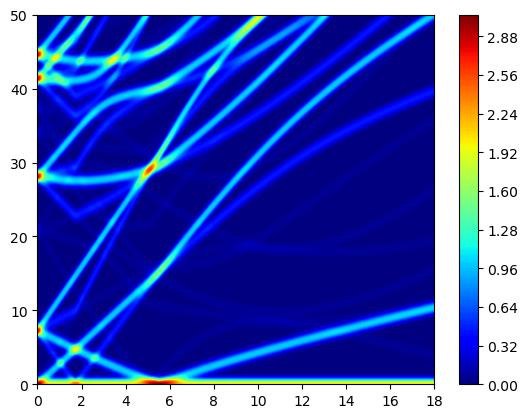

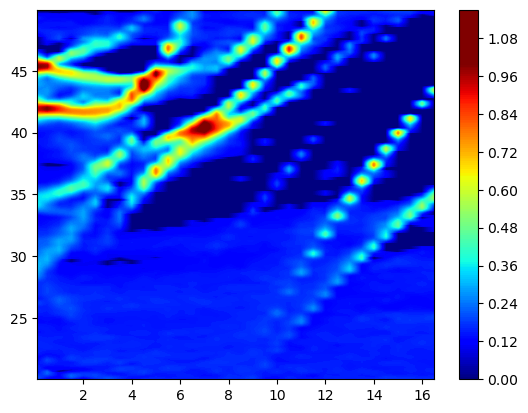

In [562]:
# plt.contourf( Bfield,wavenums, normDataC.T,50, cmap ='cool')
plt.contourf( np.linspace(0,18,360),np.linspace(0, 50,1000),Z.T, 200,  cmap='jet')
# plt.clim(0,1)
# plt.ylim(20,100)
plt.colorbar()

plt.figure()
plt.contourf(Bfield, wavenums, normDataC.T, 200, cmap = 'jet')
# plt.ylim(40,50)
plt.clim(0,1)
plt.colorbar()

# now let's do the fitting in lmfit?
starting guess params from https://journals.aps.org/prb/pdf/10.1103/PhysRevB.101.144432

In [563]:
model = lmfit.Model(zeemanSplit, independent_vars=['field', 'wavenum'])
params = model.make_params()

params['B20'].set(value= B20)
params['B40'].set(value= B40)
params['B43'].set(value= B43)
params['B60'].set(value= B60)
params['B63'].set(value= B63)
params['B66'].set(value= B66)

z = np.array(normDataC.to_numpy()) # gotta do it twice with tuples :((((
# z = z

result = model.fit(z, field=Bfield, wavenum=wavenums, params =params)

In [564]:
print(result.fit_report())

[[Model]]
    Model(zeemanSplit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1030
    # data points      = 16932
    # variables        = 6
    chi-square         = 2050.89714
    reduced chi-square = 0.12116845
    Akaike info crit   = -35730.2328
    Bayesian info crit = -35683.8111
    R-squared          = -4.13684748
[[Variables]]
    B20: -0.02613641 +/- 9.8052e-05 (0.38%) (init = -0.02773)
    B40: -4.0973e-04 +/- 2.0309e-07 (0.05%) (init = -0.0003987)
    B43: -0.01419494 +/- 7.2321e-06 (0.05%) (init = -0.01416)
    B60:  3.1616e-06 +/- 1.3948e-09 (0.04%) (init = 3.152e-06)
    B63: -9.2106e-06 +/- 7.4866e-08 (0.81%) (init = -7.616e-06)
    B66:  3.1058e-05 +/- 8.8291e-08 (0.28%) (init = 3.275e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(B20, B63) = -0.9746
    C(B43, B66) = -0.9378
    C(B20, B66) = -0.8991
    C(B63, B66) = +0.8342
    C(B20, B43) = +0.7937
    C(B43, B63) = -0.7073
    C(B40, B63) = +0.6706
    C(B20, B40)

# now let's plot the fit

In [589]:
# first, make the simulated data
waveArr= np.linspace(0,100, 500)
fieldArr = np.linspace(0,16.5, 100)
arr = zeemanSplit(fieldArr, waveArr,result.params['B20'], result.params['B40'], result.params['B43'], result.params['B60'], result.params['B63'], result.params['B66']) 
arr = np.array(arr)

Text(0.5, 1.0, 'CsErSe2 H||b real data')

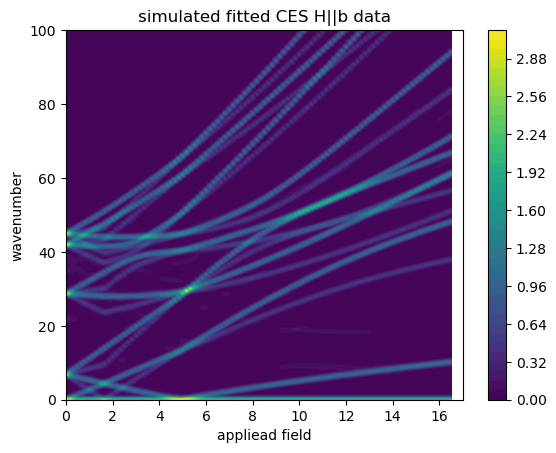

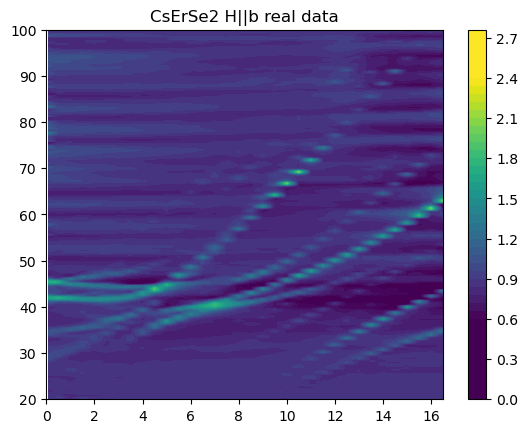

In [594]:
# then plot
plt.contourf(fieldArr,waveArr,arr.T, 50)
plt.xlim(0,17)
# plt.ylim(20,50)
# plt.clim(0,.5)
plt.title('simulated fitted CES H||b data')
plt.xlabel('appliead field')
plt.ylabel('wavenumber')
plt.colorbar()

plt.figure()
plt.contourf(rawBfield,rawwavenums, rawData.T,50)
plt.xlim(0,16.5)
plt.ylim(20,100)
plt.clim(.6,2.4)
plt.colorbar()
plt.title('CsErSe2 H||b real data')

In [571]:
def diagonalizeC(ionObj, ion, Field): 
    JdotB = muB*(Field*cef.Operator.Jz(ionObj.J))*cef.LandeGFactor(ion)
    H = np.sum([a*b for a,b in zip(ionObj.O, ionObj.B)], axis=0)
    ionObj.diagonalize(H + JdotB.O) # this is just H = Hcef + Hmag
    return ionObj.eigenvalues 

def zeemanSplitLinesC(field, B20, B40, B43, B60, B63, B66):     
    # assuming only H||B rn
    # assuming that x is an array
    amp = []#[1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1,]#[0, .15, .15, .2, 0.15,0.15,0.15,0.15,0.07,0.07, .1,.1,.1,.1,.1]
    Bparams =  {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
    ionObj = cef.CFLevels.Bdict(ion,Bparams)
    kBT = 5*kB
    try: # for the case we pass in a single B val
        evals = diagonalizeC(ionObj, ion, field)
        dE =[eval for eval in evals] # this is the spitting if everything is in the GS -> not necessarily true for finite temp
        # first, lets calculate the partition function - the microstates of the system don't change, jsut the number of abs line
        # we can make between them, so we can make this now
        # Z = sum_i (e^(-beta*E_i))
        Z = [np.exp(-Ei/kBT) for Ei in dE]
        Z = sum(Z)
        # now that we have the partition fn, we can calculate probabilities
        p = [1/Z*np.exp(-Ei/kBT) for Ei in dE]
        # okay, so now we want to add lines between non ground states 
        # we want the amplitude to be the probability -> main lines are already determined
        numLines = len(dE)
        for i in range(1,numLines): 
            # skip GS - already have those dE
            for j in range(i+1, numLines):
                temp = dE[j]-dE[i]
                dE.append(temp)
        amp.append(p)
        # so now we want to create a multi gaussian with centers at the eigenvalues
    except AttributeError : # for when we pass in an array 
        # pyCrystalField has trouble with the operators because its not *just* a function
        # so this error handling lets us have a function that works for single values and array inputs
        amp = []
        dE = []
        for b in field: 
            evals = diagonalize(ionObj, ion, b)
            dE_temp =[eval for eval in evals] # this is the spitting if everything is in the GS -> not necessarily true for finite temp
            # first, lets calculate the partition function - the microstates of the system don't change, jsut the number of abs line
            # we can make between them, so we can make this now
            # Z = sum_i (e^(-beta*E_i))
            Z = [np.exp(-Ei/kBT) for Ei in dE_temp]
            Z = sum(Z)
            # now that we have the partition fn, we can calculate probabilities
            p = [1/Z*np.exp(-Ei/kBT) for Ei in dE_temp]
            # temp_amp = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1,]
            # okay, so now we want to add lines between non ground states 
            # we want the amplitude to be the probability -> main lines are already determined
            numLines = len(dE_temp)
            for i in range(1,numLines): 
                # skip GS - already have those dE
                for j in range(i+1, numLines):
                    temp = dE_temp[j]-dE_temp[i]
                    dE_temp.append(temp)
                    # temp_amp.append(p[i])
            dE.append(dE_temp)
            amp.append(p)
    return amp, dE

In [572]:
waveArr= np.linspace(0,8000, 16000)
fieldArr = np.linspace(0,18, 100)

ampC, arrC = zeemanSplitLinesC(fieldArr,result.params['B20'], result.params['B40'], 
                   result.params['B43'], result.params['B60'], 
                   result.params['B63'], result.params['B66'])
arrC = np.array(arrC)
arrC = arrC*meVToCm
arrC = arrC.T

ampC = np.array(ampC)
ampC = ampC.T

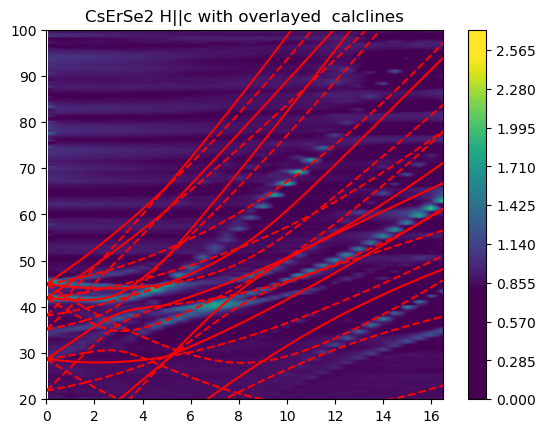

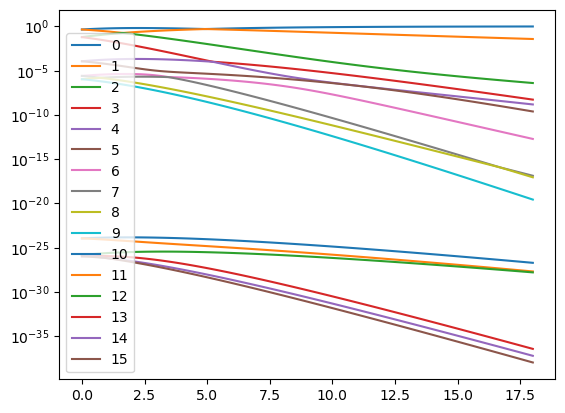

In [587]:
rawBfield =[float(i) for i in rawData.index.values]
rawwavenums = [float(b) for b in rawData.columns.values]

# rawData = rawData.values.max()-rawData

plt.contourf(rawBfield, rawwavenums, rawData.T,200)
plt.xlim(0,16.5)
plt.ylim(0,120)
plt.clim(.8, 2.5)
plt.colorbar()
plt.title('CsErSe2 H||c with overlayed  calclines')
for i in range(40):
    if i<16: 
        plt.plot(fieldArr, arrC[i], 'r')
    if i>=16: 
        plt.plot(fieldArr, arrC[i], 'r--')

plt.ylim(20, 100)

fig = plt.figure()
for i in range(len(ampC)):
    plt.plot(fieldArr, ampC[i], label =str(i))
plt.yscale('log')
plt.legend()

# now lets compare to the values from the neutrom data

Text(0, 0.5, 'Applied Field (T)')

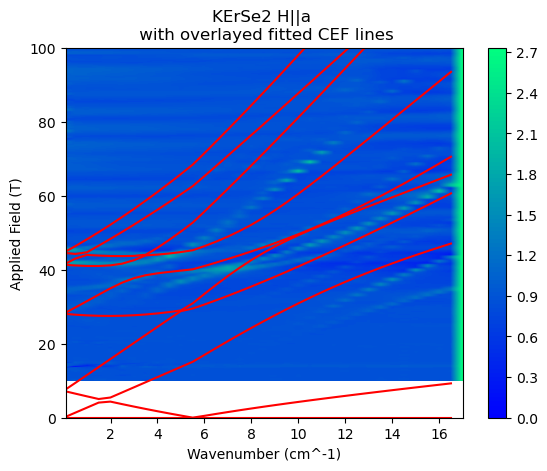

In [597]:
calc = dummyModelB(B20, B40, B43, B60, B63, B66)
plt.figure()
plotCalcZSpec(calc, Bfield)
plt.contourf(rawBfield,rawwavenums,  rawData.T,100, cmap ='winter')
plt.colorbar()
# plt.clim(.1,.6)
plt.title('KErSe2 H||a \n with overlayed fitted CEF lines')
# plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Applied Field (T)')